In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.frozen import FrozenEstimator

from sklearn.metrics import brier_score_loss, log_loss

from sklearn.datasets import make_blobs

Этот пример иллюстрирует, как калибровка Платта изменяет прогнозируемые вероятности для задачи классификации по 3 классам. 

На рисунке показан стандартный симплекс (вариант n-мерного тетраэдра), где три угла соответствуют трем классам. Стрелки указывают вектора вероятности, предсказанные некалиброванным классификатором, к векторам вероятности, предсказанным тем же классификатором после калибровки сигмовидной формы с помощью набора для предварительной проверки. Цвета указывают на истинный класс экземпляра (красный: класс 1, зеленый: класс 2, синий: класс 3).

### Данные

оздаем классификационный набор данных с 2000 строками, 2 признаками и 3 целевыми классами. Затем мы разделяем данные следующим образом:
- обучаем: 600 строк используем для обучения классификатора
- валидации 400 строк используем для калибровки прогнозируемых вероятностей.
- теста 1000 строк

Обратите внимание, что мы также создаем X_train_valid и y_train_valid, которые состоят как из обучающего, так и из валидационного набора строк. Это используется, когда мы хотим только обучить классификатор, но не калибровать прогнозируемые вероятности.

In [2]:
np.random.seed(0)

X, y = make_blobs(
    n_samples=2000, n_features=2, centers=3, random_state=42, cluster_std=5.0
)
X_train, y_train = X[:600], y[:600]
X_valid, y_valid = X[600:1000], y[600:1000]
X_train_valid, y_train_valid = X[:1000], y[:1000]
X_test, y_test = X[1000:], y[1000:]

In [3]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=25)
clf.fit(X_train_valid, y_train_valid)

RandomForestClassifier(n_estimators=25)

**Внимание для замораживания обученного классификатора, и запрета на его `refit` в кросс-валидации используем `FrozenEstimator`**

In [4]:
clf = RandomForestClassifier(n_estimators=25)
clf.fit(X_train, y_train)
cal_clf = CalibratedClassifierCV(FrozenEstimator(clf), method="sigmoid")
cal_clf.fit(X_valid, y_valid)

CalibratedClassifierCV(estimator=FrozenEstimator(estimator=RandomForestClassifier(n_estimators=25)))

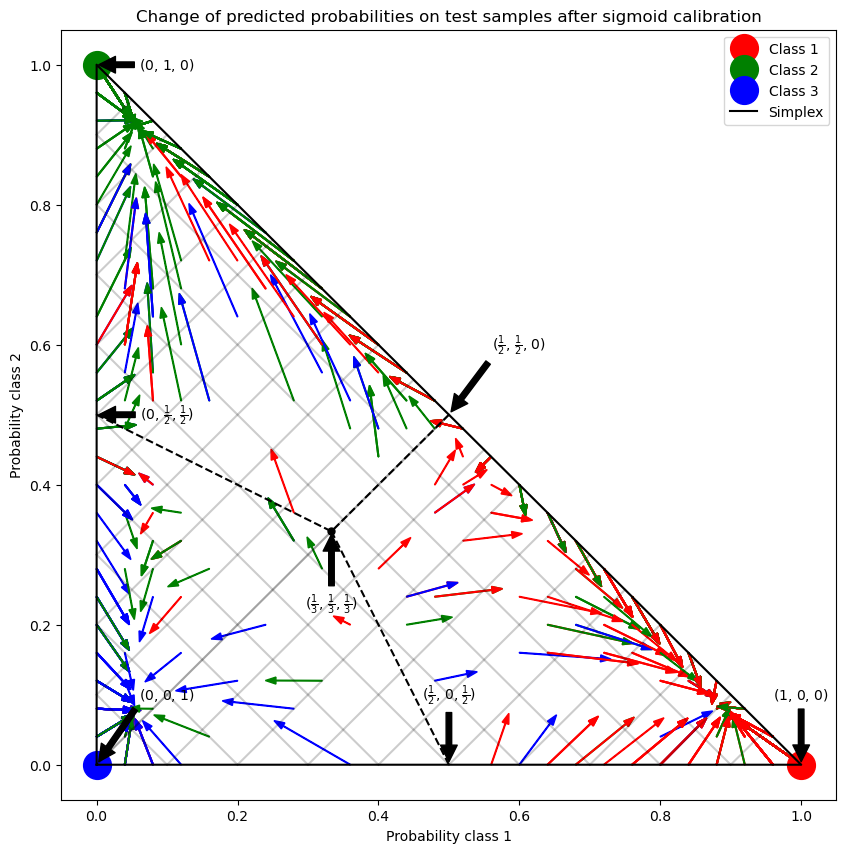

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
colors = ["r", "g", "b"]

clf_probs = clf.predict_proba(X_test)
cal_clf_probs = cal_clf.predict_proba(X_test)
# Plot arrows
for i in range(clf_probs.shape[0]):
    plt.arrow(
        clf_probs[i, 0],
        clf_probs[i, 1],
        cal_clf_probs[i, 0] - clf_probs[i, 0],
        cal_clf_probs[i, 1] - clf_probs[i, 1],
        color=colors[y_test[i]],
        head_width=1e-2,
    )

# Plot perfect predictions, at each vertex
plt.plot([1.0], [0.0], "ro", ms=20, label="Class 1")
plt.plot([0.0], [1.0], "go", ms=20, label="Class 2")
plt.plot([0.0], [0.0], "bo", ms=20, label="Class 3")

# Plot boundaries of unit simplex
plt.plot([0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], "k", label="Simplex")

# Annotate points 6 points around the simplex, and mid point inside simplex
plt.annotate(
    r"($\frac{1}{3}$, $\frac{1}{3}$, $\frac{1}{3}$)",
    xy=(1.0 / 3, 1.0 / 3),
    xytext=(1.0 / 3, 0.23),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.plot([1.0 / 3], [1.0 / 3], "ko", ms=5)
plt.annotate(
    r"($\frac{1}{2}$, $0$, $\frac{1}{2}$)",
    xy=(0.5, 0.0),
    xytext=(0.5, 0.1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($0$, $\frac{1}{2}$, $\frac{1}{2}$)",
    xy=(0.0, 0.5),
    xytext=(0.1, 0.5),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($\frac{1}{2}$, $\frac{1}{2}$, $0$)",
    xy=(0.5, 0.5),
    xytext=(0.6, 0.6),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($0$, $0$, $1$)",
    xy=(0, 0),
    xytext=(0.1, 0.1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($1$, $0$, $0$)",
    xy=(1, 0),
    xytext=(1, 0.1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($0$, $1$, $0$)",
    xy=(0, 1),
    xytext=(0.1, 1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
# Add grid
plt.grid(False)
for x in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.plot([0, x], [x, 0], "k", alpha=0.2)
    plt.plot([0, 0 + (1 - x) / 2], [x, x + (1 - x) / 2], "k", alpha=0.2)
    plt.plot([x, x + (1 - x) / 2], [0, 0 + (1 - x) / 2], "k", alpha=0.2)

plt.plot( [1/2, 1.0/3], [0, 1.0/3],
         [0, 1.0/3], [1/2, 1.0/3], 
         [1/2, 1.0/3], [1/2, 1.0/3],
        linestyle='dashed', color ='k')

plt.title("Change of predicted probabilities on test samples after sigmoid calibration")
plt.xlabel("Probability class 1")
plt.ylabel("Probability class 2")
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
_ = plt.legend(loc="best")

На рисунке выше каждая вершина симплекса представляет 
собой идеально предсказанный класс (например, 1, 0, 0). Средняя точка внутри симплекса представляет собой предсказание трех классов с равной вероятностью (т.е. 1/3, 1/3, 1/3). Каждая стрелка начинается с некалиброванных вероятностей и заканчивается наконечником стрелки с калиброванной вероятностью. Цвет стрелки указывает на истинный класс этого тестируемого образца.

Некалиброванный классификатор слишком уверен в своих прогнозах и приводит к большим ошибкам `log_loss`. 

Калиброванный классификатор приводит к меньшим ошибкам `log_loss` из-за двух факторов: 
- во-первых, обратите внимание на приведенный выше рисунок, что стрелки обычно указывают в сторону от краев симплекса, где вероятность каждого класса равна 0.
- во-вторых, большая часть стрелок указывает на истинный класс, например, зеленые стрелки (образцы, где истинный класс "зеленый") обычно указывают на зеленую вершину. Это приводит к уменьшению числа прогнозируемых вероятностей, равному 0, и в то же время к увеличению прогнозируемых вероятностей правильного класса. Таким образом, калиброванный классификатор выдает более точные прогнозируемые вероятности, которые приводят к меньшим потерям в логарифмах

Мы можем показать это объективно, сравнив `log_loss` некалиброванного и откалиброванного классификаторов с прогнозами 1000 тестовых образцов. Обратите внимание, что альтернативой могло бы быть увеличение числа базовых оценок (деревьев) классификатора RandomForestClassifier, что привело бы к аналогичному уменьшению `log_loss`.

In [6]:
score = log_loss(y_test, clf_probs)
cal_score = log_loss(y_test, cal_clf_probs)

print("Log-loss of")
print(f" * uncalibrated classifier: {score:.3f}")
print(f" * calibrated classifier: {cal_score:.3f}")

Log-loss of
 * uncalibrated classifier: 1.327
 * calibrated classifier: 0.549


Теперь, создадим сетку возможных некалиброванных вероятностей (точки внутри стандартного симплаекса), вычисляем соответствующие калиброванные вероятности и наносим стрелки для каждой из них. Стрелки окрашены в соответствии с наибольшей некалиброванной вероятностью. Это иллюстрирует полученную карту калибровки:

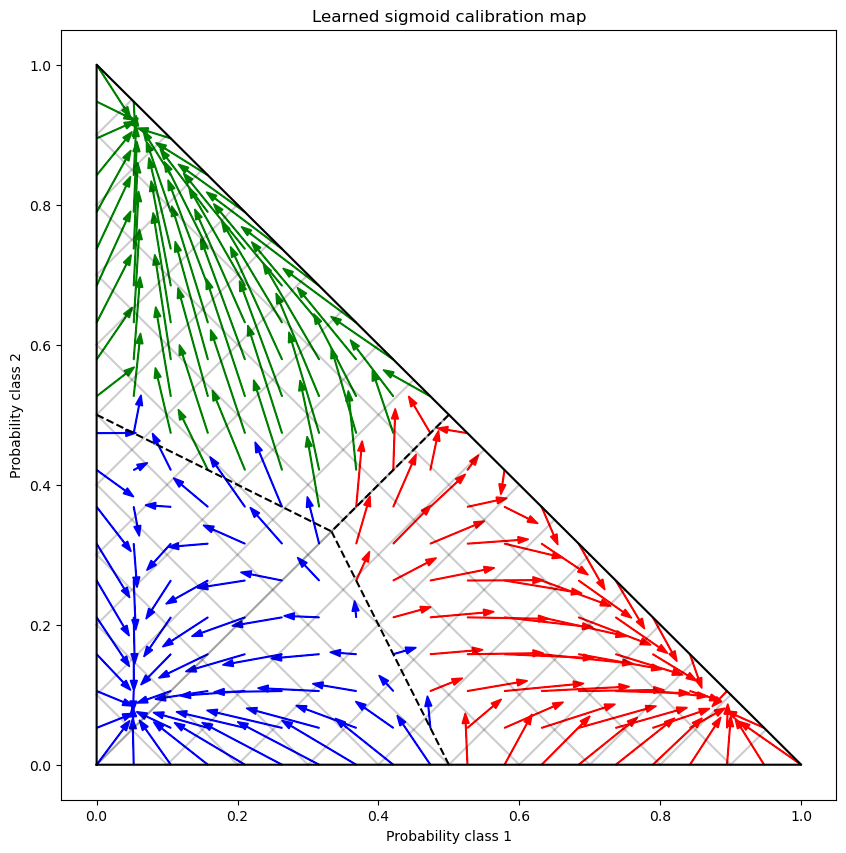

In [7]:
plt.figure(figsize=(10, 10))
# Generate grid of probability values
p1d = np.linspace(0, 1, 20)
p0, p1 = np.meshgrid(p1d, p1d)
p2 = 1 - p0 - p1
p = np.c_[p0.ravel(), p1.ravel(), p2.ravel()]
p = p[p[:, 2] >= 0]

# Use the three class-wise calibrators to compute calibrated probabilities
calibrated_classifier = cal_clf.calibrated_classifiers_[0]
prediction = np.vstack(
    [
        calibrator.predict(this_p)
        for calibrator, this_p in zip(calibrated_classifier.calibrators, p.T)
    ]
).T

# Re-normalize the calibrated predictions to make sure they stay inside the
# simplex. This same renormalization step is performed internally by the
# predict method of CalibratedClassifierCV on multiclass problems.
prediction /= prediction.sum(axis=1)[:, None]

# Plot changes in predicted probabilities induced by the calibrators
for i in range(prediction.shape[0]):
    plt.arrow(
        p[i, 0],
        p[i, 1],
        prediction[i, 0] - p[i, 0],
        prediction[i, 1] - p[i, 1],
        head_width=1e-2,
        color=colors[np.argmax(p[i])],
    )

# Plot the boundaries of the unit simplex
plt.plot([0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], "k", label="Simplex")

plt.grid(False)
for x in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.plot([0, x], [x, 0], "k", alpha=0.2)
    plt.plot([0, 0 + (1 - x) / 2], [x, x + (1 - x) / 2], "k", alpha=0.2)
    plt.plot([x, x + (1 - x) / 2], [0, 0 + (1 - x) / 2], "k", alpha=0.2)

plt.plot( [1/2, 1.0/3], [0, 1.0/3],
         [0, 1.0/3], [1/2, 1.0/3], 
         [1/2, 1.0/3], [1/2, 1.0/3],
        linestyle='dashed', color ='k')



plt.title("Learned sigmoid calibration map")
plt.xlabel("Probability class 1")
plt.ylabel("Probability class 2")
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

plt.show()